# Data and Scaling

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import pickle 
df = pd.read_csv("../PreProcessamentoDados/cleanedData.csv")

In [46]:
df[['Hour','Minute','Second']] = df.DateTime.str.split(":",expand=True)

In [49]:
df.dtypes

DateTime                   object
Generated power           float64
TemperatureC              float64
DewpointC                 float64
PressurehPa               float64
WindDirectionDegrees      float64
WindSpeedKMH              float64
WindSpeedGustKMH          float64
Humidity                  float64
HourlyPrecipMM            float64
dailyrainMM               float64
SolarRadiationWatts_m2    float64
Hour                      float64
Minute                    float64
Second                     object
dtype: object

In [48]:
# define a dictionary of column names and their corresponding data types
dtypes_dict = {'Hour': float, 'Minute': float}

# convert the columns to their corresponding data types
df = df.astype(dtypes_dict)

In [50]:
df.head()

,DateTime,Generated power,TemperatureC,DewpointC,PressurehPa,WindDirectionDegrees,WindSpeedKMH,WindSpeedGustKMH,Humidity,HourlyPrecipMM,dailyrainMM,SolarRadiationWatts_m2,Hour,Minute,Second
0,00:15:00,0.0,11.0,8.0,1021.0,128.333333,8.666667,17.000000,83.000000,0.0,0.0,0.0,0.0,15.0,00
1,00:30:00,0.0,11.0,8.0,1021.0,133.333333,1.333333,19.000000,83.000000,0.0,0.0,0.0,0.0,30.0,00
2,00:45:00,0.0,11.0,8.0,1021.0,127.666667,3.000000,12.333333,82.333333,0.0,0.0,0.0,0.0,45.0,00
3,01:00:00,0.0,11.0,8.0,1021.0,128.000000,1.333333,10.000000,81.000000,0.0,0.0,0.0,1.0,0.0,00
4,01:15:00,0.0,11.0,8.0,1021.0,130.000000,2.666667,11.000000,80.666667,0.0,0.0,0.0,1.0,15.0,00


In [51]:
Y = df['Generated power']
X = df.drop(columns=['Generated power','DateTime','Second'])

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)



In [53]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
X_train

array([[-0.81583623, -0.69182852, -0.24383915, ..., -0.69893303,
        -1.31304701, -0.45861175],
       [ 0.3058588 ,  0.95698922, -0.73936116, ..., -0.69893303,
        -1.02458051, -0.45861175],
       [-1.8194581 , -1.72233961,  1.90342287, ..., -0.69893303,
        -1.60151351, -0.45861175],
       ...,
       [-0.57968991, -0.07352187,  1.57307487, ..., -0.69893303,
        -1.16881376, -1.35675152],
       [-0.22547042,  0.54478479, -0.24383915, ..., -0.69893303,
        -1.31304701, -1.35675152],
       [-0.284507  ,  0.54478479,  0.85732086, ...,  0.12438398,
        -0.15918101,  1.3376678 ]])

# ###############################

# Hyperparameter tuning

In [30]:
from itertools import chain

# from: https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b
# from: https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide

# List of numbers to choose from
n = len(X.columns)-1
numbers = [n, 2*n, n//2, n//4]

# Get the combinations of length 2, 3 and 4
combinations_2 = list(itertools.combinations(numbers, 2))
combinations_3 = list(itertools.combinations(numbers, 3))
combinations_4 = list(itertools.combinations(numbers, 4))


# Concatenate the lists of combinations
combinations = list(chain(combinations_2, combinations_3, combinations_4))

mlp_gs = MLPRegressor(max_iter = 10000)
parameter_space = {
    'hidden_layer_sizes': combinations,
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01, 0.1, 0.5, 0.9],
    'learning_rate': ['constant','adaptive']
}
# grid search
# clf = RandomizedSearchCV(mlp_gs, parameter_space, n_jobs = 9, cv = 3, random_state = 24, scoring = metrics.r2_score)

clf = RandomizedSearchCV(mlp_gs, parameter_space, n_jobs = 9, cv = 3, random_state = 24)
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels

y_true, y_pred = y_test, clf.predict(X_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
print("\n R2 Score: \n",r2)
#from: https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", clf.best_estimator_)
print("\n The best score across ALL searched params:\n", clf.best_score_)
print("\n The best parameters across ALL searched params:\n", clf.best_params_)

Results from Random Search 

 The best estimator across ALL searched params:
 MLPRegressor(alpha=0.5, hidden_layer_sizes=(10, 20, 5), max_iter=10000)

 The best score across ALL searched params:
 0.866832250357974

 The best parameters across ALL searched params:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 20, 5), 'alpha': 0.5, 'activation': 'relu'}

# ###############################

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_reg = MLPRegressor(max_iter = 10000)

grid = GridSearchCV(mlp_reg, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train,y_train)

print(grid.best_params_)

In [ ]:
grid_predictions = grid.predict(X_train) 
from sklearn.metrics import r2_score
r2_score(y_true, grid_predictions)

In [ ]:
df_temp2 = pd.DataFrame({'Actual': y_true, 'Predicted': grid_predictions})
df_temp2.head()

In [ ]:
import matplotlib.pyplot as plt

df_temp2 = df_temp2.head(30)
df_temp2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, grid_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_true, grid_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, grid_predictions)))

# ##############################

# Just create the model

In [67]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(10,2,5),
                       max_iter = 10000,activation = 'relu',
                       solver = 'adam',
                       learning_rate='constant',
                       alpha=0.5)



# Fit 

In [68]:
mlp_reg.fit(X_train, y_train) # X is train samples and y is the corresponding labels

MLPRegressor(alpha=0.5, hidden_layer_sizes=(10, 2, 5), max_iter=10000)

# Predict

In [69]:
y_true, y_pred = y_test, mlp_reg.predict(X_test)

# Evaluation
# https://michael-fuchs-python.netlify.app/2021/02/10/nn-multi-layer-perceptron-regressor-mlpregressor/
# https://michael-fuchs-python.netlify.app/2019/06/30/metrics-for-regression-analysis/

In [76]:
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.8748393020212462

In [77]:
mlp_reg.score(X_test,y_true)


0.8748393020212462

In [59]:
df_temp = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
49107,2080.000000,1924.958584
54390,3574.666667,4284.479328
1864,4072.333333,3503.503397
26373,0.000000,27.045843
58115,4403.333333,4300.160364


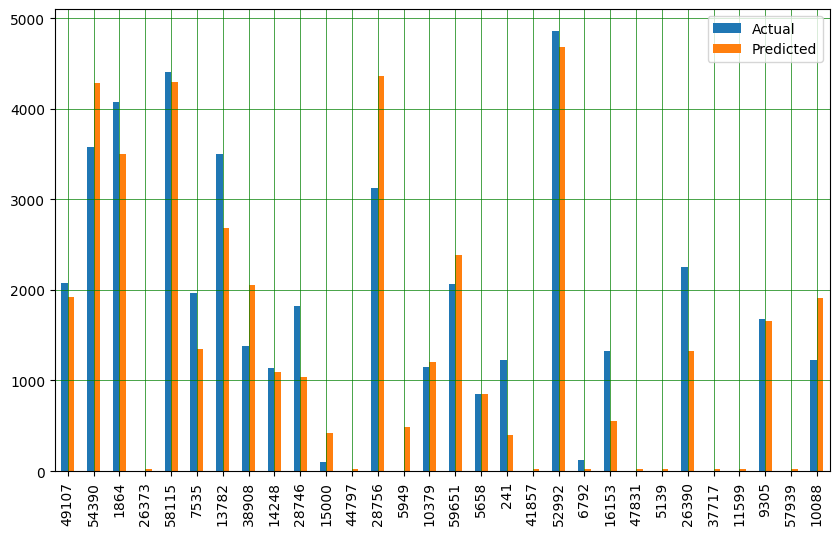

In [60]:
import matplotlib.pyplot as plt

df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [62]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_true, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_true, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

Mean Absolute Error: 241.9078381996166
Mean Squared Error: 216336.3351824172
Root Mean Squared Error: 465.1196998434029


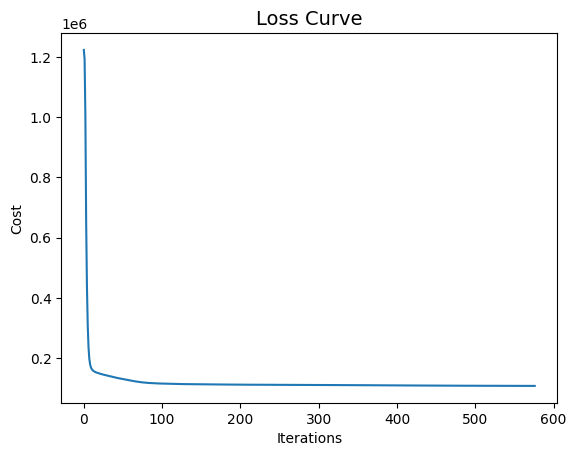

In [63]:
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

Save the Model with Pickle

In [71]:
# save the model to disk
filename = 'MLPRegressor_finalized_model.pkl'
pickle.dump(mlp_reg, open(filename, 'wb'))

In [78]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test,y_true)
y_true2, y_pred2 = y_test, loaded_model.predict(X_test)
r2s = r2_score(y_true2, y_pred2)

print(result)
print(r2s)

0.8748393020212462
0.8748393020212462


# Testing

# #######################3

In [ ]:
from sklearn import metrics


expected_y = y_true
predicted_y = y_pred

print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_log_error(expected_y, predicted_y))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})